# Common libraries import

In [4]:
# common
import json
import pandas as pd
import sys

# Display all rows and columns of pandas dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# data preprocessing
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

# classifiers
from sklearn.ensemble import RandomForestClassifier

# Grid search
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config

set_config(display="diagram")

# Warnings
import os
import warnings
from sklearn.exceptions import ConvergenceWarning

# ignore warnings for clarity of output
# reference: https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ[
        "PYTHONWARNINGS"
    ] = "ignore::ConvergenceWarning,ignore::UserWarning,ignore::RuntimeWarning"

# Helper functions

In [7]:
def print_accuracy(accuracy_score, score_text=False):
    """
    Take an accuracy score between 0 and 1 and print output to screen cleanly
    """
    clean_accuracy = accuracy_score * 100.0
    if score_text:
        clean_text = score_text.strip() + " "
        print("{}{:.2f}%".format(clean_text, clean_accuracy))
    else:
        print("{:.2f}%".format(clean_accuracy))


def summarize_results(grid_result, x_test, y_test, model_name):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print_accuracy(
        accuracy_score(y_test, grid_result.best_estimator_.predict(x_test)), model_name
    )
    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]
    params = grid_result.cv_results_["params"]
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

# Global configuration

In [10]:
# Nice range encoder for hyperparams serialization
class RangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, range):
            return list(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


config = {
    "GLOBAL": {
        "test_size": 0.30,
        "cross_validation_splits": 10,
        "random_state": 42,
    },
    "RandomForest": {
        "featureSelector__n_features_to_select": [1.0],
        "classifier__n_estimators": [1000],
        "classifier__criterion": ["entropy"],
    },
}

with open("config.json", "w") as f:
    json.dump(config, f, cls=RangeEncoder)

# Data loading

In [13]:
# data loading (I did not public the data folder)
data_file_polyps = "../data/polyps.xlsx"
data_file_wzjg = "../data/wzjg.xlsx"
dataset_polyps = pd.read_excel(data_file_polyps)
dataset_wzjg = pd.read_excel(data_file_wzjg)
dataset = pd.concat([dataset_polyps, dataset_wzjg])

# Initial preprocessing

In [26]:
def preprocess(dataset):
    list = ['CEA', 'Cholesterol LDL', 'HBE ANTYGEN  INTERPRETACJA', 
            'KAŁ NA PASOŻYTY (MET MIKROSKOPOWA)', 'Kalprotektyna w kale', 
            'Kreatynina w surowicy.', 'MOCZ - BADANIE OGÓLNE GLUKOZA',
            'MOCZ - BADANIE OGÓLNE BAKTERIE.', 'MORFOLOGIA 5 DIFF ERYTROCYTY',
            'MORFOLOGIA 5 DIFF HEMOGLOBINA', 'MORFOLOGIA 5 DIFF MCH',
            'MORFOLOGIA LEUKOCYTY', 'MORFOLOGIA P-LCR',
            'OB', 'Płeć', 'Wiek']
    df = pd.DataFrame(dataset)
    colums = df.columns.tolist()
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df = df.drop(["P/CIALA ANTY-HBC II  INTERPRETACJA"], axis=1)
    x = df.drop(["Rozpoznanie choroby:"], axis=1)
    x = x[list]
    y = df["Rozpoznanie choroby:"]
    return x, y

In [28]:
x, y = preprocess(dataset)

# Train-test split

In [30]:
# First dataset splitting
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=config["GLOBAL"]["test_size"],
    random_state=config["GLOBAL"]["random_state"],
    stratify=y,
)

# Random Forest Pipeline

In [54]:
pipeline_RF = Pipeline(
    steps=[
        ("imputer", IterativeImputer(max_iter=10)),
        (
            "featureSelector",
            SequentialFeatureSelector(
                estimator=RandomForestClassifier(),
                n_features_to_select=1.0
            ),
        ),
        ("classifier", RandomForestClassifier()),
    ]
)
pipeline_RF.fit(x_train, y_train)

param_grid = [config["RandomForest"]]
grid_search_RF = GridSearchCV(
    pipeline_RF,
    param_grid,
    cv=config["GLOBAL"]["cross_validation_splits"],
    verbose=2,
    n_jobs=-1,
)
grid_search_RF.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', IterativeImputer()),
                                       ('featureSelector',
                                        SequentialFeatureSelector(estimator=RandomForestClassifier(),
                                                                  n_features_to_select=1.0)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier__criterion': ['entropy'],
                          'classifier__n_estimators': [1000],
                          'featureSelector__n_features_to_select': [1.0]}],
             verbose=2)

In [56]:
summarize_results(grid_search_RF, x_test, y_test, "RF_pipeline")

Best: 0.857525 using {'classifier__criterion': 'entropy', 'classifier__n_estimators': 1000, 'featureSelector__n_features_to_select': 1.0}
RF_pipeline 83.16%
0.857525 (0.026519) with: {'classifier__criterion': 'entropy', 'classifier__n_estimators': 1000, 'featureSelector__n_features_to_select': 1.0}


# Random Forest - Feature Importance

In [59]:
mask_RF = grid_search_RF.best_estimator_.named_steps["featureSelector"].get_support()
x_train.columns[mask_RF]

Index(['CEA', 'Cholesterol LDL', 'HBE ANTYGEN  INTERPRETACJA',
       'KAŁ NA PASOŻYTY (MET MIKROSKOPOWA)', 'Kalprotektyna w kale',
       'Kreatynina w surowicy.', 'MOCZ - BADANIE OGÓLNE GLUKOZA',
       'MOCZ - BADANIE OGÓLNE BAKTERIE.', 'MORFOLOGIA 5 DIFF ERYTROCYTY',
       'MORFOLOGIA 5 DIFF HEMOGLOBINA', 'MORFOLOGIA 5 DIFF MCH',
       'MORFOLOGIA LEUKOCYTY', 'MORFOLOGIA P-LCR', 'OB', 'Płeć', 'Wiek'],
      dtype='object')

<Axes: >

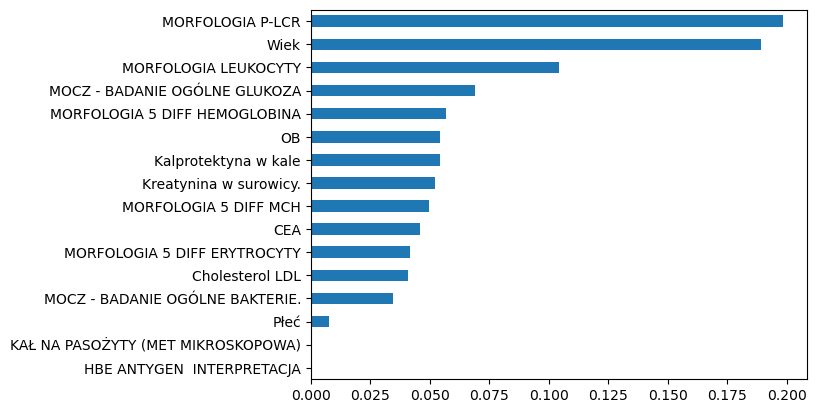

In [61]:
features_RF = x_train.columns[mask_RF]
coef_RF = grid_search_RF.best_estimator_.named_steps["classifier"].feature_importances_
feature_importance_RF = pd.Series(abs(coef_RF.flatten()), features_RF)
feature_importance_RF.sort_values().plot.barh()

In [77]:
feature_importance_RF.sort_values()

HBE ANTYGEN  INTERPRETACJA            0.000000
KAŁ NA PASOŻYTY (MET MIKROSKOPOWA)    0.000000
Płeć                                  0.007616
MOCZ - BADANIE OGÓLNE BAKTERIE.       0.034669
Cholesterol LDL                       0.040873
MORFOLOGIA 5 DIFF ERYTROCYTY          0.041659
CEA                                   0.045991
MORFOLOGIA 5 DIFF MCH                 0.049629
Kreatynina w surowicy.                0.052291
Kalprotektyna w kale                  0.054343
OB                                    0.054377
MORFOLOGIA 5 DIFF HEMOGLOBINA         0.056940
MOCZ - BADANIE OGÓLNE GLUKOZA         0.069184
MORFOLOGIA LEUKOCYTY                  0.104460
Wiek                                  0.189431
MORFOLOGIA P-LCR                      0.198538
dtype: float64

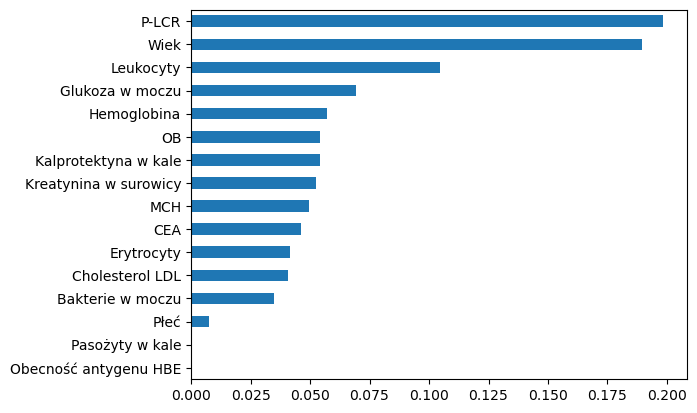

In [121]:
x = [
    "Obecność antygenu HBE", 
    "Pasożyty w kale", 
    "Płeć", 
    "Bakterie w moczu", 
    "Cholesterol LDL", 
    "Erytrocyty", 
    "CEA", 
    "MCH", 
    "Kreatynina w surowicy", 
    "Kalprotektyna w kale", 
    "OB", 
    "Hemoglobina", 
    "Glukoza w moczu", 
    "Leukocyty", 
    "Wiek", 
    "P-LCR"
]
y = [0.0, 0.0, 0.007616, 0.034669, 0.040873, 0.041659, 0.045991, 0.049629, 0.052291, 0.054343, 0.054377, 0.056940, 0.069184, 0.104460, 0.189431, 0.198538]

df = pd.DataFrame(
    y, x)

df.plot.barh(legend=False)
plt.savefig('UCImportance.pdf', bbox_inches='tight')
plt.show()

# Saving Models

In [64]:
RF_best = grid_search_RF.best_estimator_

In [18]:
# 'models' folder was used in development and was not included
folder_path = "../models/"

In [68]:
# save the best estimator (IMPORTANT!!! RandomForestAllFeaturesNoScaling.pkl was later changed to RandomForest_UC.pkl)
joblib.dump(RF_best, str(folder_path) + "RandomForestAllFeaturesNoScaling_2.pkl")

['../models/RandomForestAllFeaturesNoScaling_2.pkl']

In [52]:
RF_best_pipeline_UC = joblib.load(str(folder_path) + "RandomForestAllFeaturesNoScaling_2.pkl")
RF_best_pipeline_CD = joblib.load(str(folder_path) + "RandomForestAllFeaturesNoScaling.pkl")

In [54]:
# data retrieved for CD
data_file = "../data/50.csv"
dataset = pd.read_csv(data_file, sep=",")

In [56]:
def preprocess_CD(dataset):
    df = pd.DataFrame(dataset)
    colums = df.columns.tolist()
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    x = df.drop(["Choroba"], axis=1)
    x = x.drop(["ALAT"], axis=1)
    x = x.drop(["CRP ULTRACZUŁE"], axis=1)
    x = x.drop(["GGTP"], axis=1)
    x = x.drop(["KREATYNINA W SUROWICY  EGFR"], axis=1)
    x = x.drop(["Kreatynina w surowicy."], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF BAZOFILE#"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF EOZYNOFILE"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF MONOCYTY"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF HEMOGLOBINA"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF LEUKOCYTY"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF ERYTROBLASTY"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF NEUTROFILE#"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF NIEDOJRZAŁE GRANULOCYTY # (meta-,mielo-,promielocyt)"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF LIMFOCYTY#"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF LIMFOCYTY"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF EOZYNOFILIE#"], axis=1)
    x = x.drop(["MORFOLOGIA 5 DIFF MCV"], axis=1)
    x = x.drop(["SÓD"], axis=1)
    y = df["Choroba"]
    return x, y

In [62]:
x, y = preprocess_CD(dataset)

In [64]:
x_train_CD, x_test_CD, y_train_CD, y_test_CD = train_test_split(
    x,
    y,
    test_size=config["GLOBAL"]["test_size"],
    random_state=config["GLOBAL"]["random_state"],
    stratify=y,
)

# Precision Recall AUC

In [22]:
# imports
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, PrecisionRecallDisplay

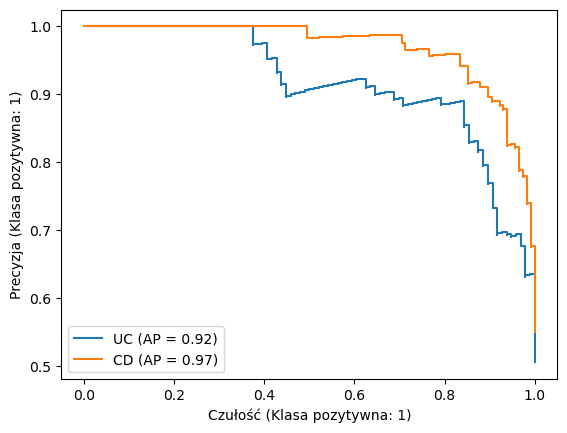

In [70]:
PrecisionRecallDisplay.from_estimator(
    RF_best_pipeline_UC, x_test, y_test, ax=plt.gca(), name="UC"
)
PrecisionRecallDisplay.from_estimator(
    RF_best_pipeline_CD, x_test_CD, y_test_CD, ax=plt.gca(), name="CD"
)
plt.xlabel("Czułość (Klasa pozytywna: 1)")
plt.ylabel("Precyzja (Klasa pozytywna: 1)")
plt.savefig('AUC.pdf', bbox_inches='tight')

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

y_predict = RF_best_pipeline.predict(x_test)
classes = RF_best_pipeline.classes_
target_names = list(map(str, classes))
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        94
           1       0.80      0.89      0.84        96

    accuracy                           0.83       190
   macro avg       0.84      0.83      0.83       190
weighted avg       0.84      0.83      0.83       190

